# Before You Running iPython notebook code 

If you running ipython notebook with python version 3.7 and install pyradiomics, you could activate two lines importing modules need to run feature extraction.  
  
However, sklearn version 1.1+, which could be only compatible with python 3.8+, only support "n_features_to_select='auto'" option in sklearn.feature_selection.SequentialFeatureSelector.  
  
Thus, it is highly recommend to deactivate two below lines and skip Feature Extraction stage and perform Featrue Extraction stage with a python script "feature_extraction.py"

# Loading Modules and Functions

## Modules

In [3]:
# basic modules
import os
import glob 
import random
import copy
from tqdm import tqdm 
from typing import Dict, Tuple

# for data processing
import numpy as np
import pandas as pd

# for radiomics features 
"""
if you running ipython notebook with python version 3.7 and install pyradiomics, you could activate those two lines below. 
However, sklearn version 1.1+, which could be only compatible with python 3.8+, only support "n_features_to_select='auto'" option in sklearn.feature_selection.SequentialFeatureSelector. 
Thus, it is highly recommend to deactivate two below lines and skip Feature Extraction stage and perform Featrue Extraction stage with a python script "feature_extraction.py"
"""
#import SimpleITK as sitk   # 
#from radiomics import featureextractor, getTestCase

# for machine learning experiments
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFECV, SelectFdr, SelectPercentile ,mutual_info_classif, f_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, make_scorer, balanced_accuracy_score
from imblearn.over_sampling import * 
from imblearn.under_sampling import * 

# machine learning algorithms 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# for hyper parameter tuning
import optuna
from optuna.samplers import TPESampler

# for visulaize 
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay
import matplotlib.pyplot as plt
%matplotlib inline



/opt/homebrew/Caskroom/miniforge/base/envs/pyRadiomics_analysis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom functions 

### data preprocessing 

In [13]:

def get_imgFile_list(nifti_Dir, mask_Dir, CT_phase='P') -> pd.DataFrame:
    """
    getting image files' directories and segmentation mask files' directories according to CT phase
    """
    nifti_subject_list = [] 
    nifti_img_list = []
    mask_subject_list = []
    mask_img_list = []

    nifti_subject_dir_list = glob.glob(os.path.join(nifti_Dir,'*'))
    for i, nifti_subject_dir in enumerate(nifti_subject_dir_list):
        subj_nifti_list = glob.glob(os.path.join(nifti_subject_dir, "*"))
        for subj_nifti in subj_nifti_list: 
            if os.path.split(subj_nifti)[-1].find('_'+CT_phase) != -1: 
                # getting subject name 
                nifti_subject_list.append(os.path.split(os.path.split(subj_nifti)[0])[-1])
                # getting specific CT phase image from subject folder 
                nifti_img_list.append(subj_nifti)
    nifti_df = pd.DataFrame({'subjectkey': nifti_subject_list, 'nifti_dir': nifti_img_list})

    mask_subject_dir_list = glob.glob(os.path.join(mask_Dir,'*'))
    for i, mask_subject_dir in enumerate(mask_subject_dir_list):
        subj_mask_list = glob.glob(os.path.join(mask_subject_dir, "*"))
        for subj_mask in subj_mask_list: 
            if os.path.split(subj_mask)[-1].find('_'+CT_phase) != -1: 
                # getting subject name 
                mask_subject_list.append(os.path.split(os.path.split(subj_mask)[0])[-1])
                # getting specific CT phase image from subject folder 
                mask_img_list.append(subj_mask)
    mask_df = pd.DataFrame({'subjectkey': mask_subject_list, 'mask_dir': mask_img_list})

    return pd.merge(nifti_df, mask_df, how='inner', on='subjectkey') 




def loading_datasets(save_Dir, CT_phase: list) -> Dict[str, pd.DataFrame]: 
    dataset = {}
    for i, phase in enumerate(CT_phase): 
        if i == 0:
            dataset_tmp = pd.read_csv(os.path.join(save_Dir, 'radiomics_features_CTphase_'+ phase + '.csv'))
            dataset[phase] = dataset_tmp

        elif i > 0: 
            dataset_tmp = pd.read_csv(os.path.join(save_Dir, 'radiomics_features_CTphase_'+ phase + '.csv'))    
            dataset[phase] = dataset_tmp


    return dataset


def assign_train_test_BinaryClassification(meta_data: pd.DataFrame, train_ratio=0.7):
    num_total_control = len(meta_data[meta_data['Pathology_binary'] == "benign"])
    num_total_case = len(meta_data[meta_data['Pathology_binary'] == "malignancy"])
    num_train_control = int(num_total_control * train_ratio)
    num_test_control = num_total_control - num_train_control

    num_train_case = int(num_total_case * train_ratio)
    num_test_case = num_total_case - num_train_case

    train_subject = []
    test_subject = []

    train_control_count = 0 
    train_case_count = 0 
    test_control_count = 0
    test_case_count = 0  
    
    assert len(meta_data[meta_data['CT phase'] >= 3]) > len(meta_data[meta_data['CT phase'] < 3])
    print("Train subjects (case/control): {}/{}. Test subjects (case/control): {}/{}.".format(num_train_case, num_train_control, num_test_case, num_test_control))
    
    for i in range(len(meta_data)):
        phase_count = meta_data.iloc[i]['CT phase']
        # assign subjects having single or 2 phase CT scans only to test set 
        if phase_count < 3: 
            if meta_data.iloc[i]['Pathology_binary'] == "benign": 
                if test_control_count <= num_test_control: 
                    test_subject.append(meta_data.iloc[i]['subjectkey'])
                    test_control_count += 1
                else:  
                    train_subject.append(meta_data.iloc[i]['subjectkey'])
                    train_control_count += 1
            elif meta_data.iloc[i]['Pathology_binary'] == "malignancy": 
                if test_case_count <= num_test_case: 
                    test_subject.append(meta_data.iloc[i]['subjectkey'])
                    test_case_count += 1
                else:  
                    train_subject.append(meta_data.iloc[i]['subjectkey'])
                    train_case_count += 1
        elif phase_count >= 3:
            if  meta_data.iloc[i]['Pathology_binary'] == "benign":
                if train_control_count <= num_train_control: 
                    train_subject.append(meta_data.iloc[i]['subjectkey'])
                    train_control_count += 1
                else: 
                    test_subject.append(meta_data.iloc[i]['subjectkey'])
                    test_control_count += 1                     
            elif meta_data.iloc[i]['Pathology_binary'] == "malignancy": 
                if train_case_count <= num_train_case: 
                    train_subject.append(meta_data.iloc[i]['subjectkey'])
                    train_case_count += 1 
                else: 
                    test_subject.append(meta_data.iloc[i]['subjectkey'])
                    test_case_count += 1                  


    return train_subject, test_subject

"""
def assign_train_test_BinaryClassification(meta_data: pd.DataFrame, train_ratio=0.7, sampling_method=None):
    num_total_control = len(meta_data[meta_data['Pathology_binary'] == "benign"])
    num_total_case = len(meta_data[meta_data['Pathology_binary'] == "malignancy"])
    num_train_control = int(num_total_control * train_ratio)
    num_test_control = num_total_control - num_train_control
    if sampling_method == 'undersampling':
        assert int(num_total_case * train_ratio) > num_train_control        # only if (the number of case > the number of train) 
        assert num_total_case - int(num_total_case * train_ratio) > num_test_control     # only if (the number of case > the number of train) 
        num_train_case = num_train_control
        num_test_case = num_test_control
    else:
        num_train_case = int(num_total_case * train_ratio)
        num_test_case = num_total_case - num_train_case
        num_test_case = num_test_control
    
    print("Train subjects (case/control): {}/{}. Test subjects (case/control): {}/{}.".format(num_train_case, num_train_control, num_test_case, num_test_control))

    train_subject = []
    test_subject = []

    train_control_count = 0 
    train_case_count = 0 
    test_control_count = 0
    test_case_count = 0  
    
    assert len(meta_data[meta_data['CT phase'] >= 3]) > len(meta_data[meta_data['CT phase'] < 3])

    
    for i in range(len(meta_data)):
        phase_count = meta_data.iloc[i]['CT phase']
        # assign subjects having 3 or 4 phase CT scans only to test set 
        if phase_count >= 3: 
            if meta_data.iloc[i]['Pathology_binary'] == "benign": 
                if test_control_count <= num_test_control: 
                    test_subject.append(meta_data.iloc[i]['subjectkey'])
                    test_control_count += 1
                else:  
                    train_subject.append(meta_data.iloc[i]['subjectkey'])
                    train_control_count += 1
            elif meta_data.iloc[i]['Pathology_binary'] == "malignancy": 
                if test_case_count <= num_test_case: 
                    test_subject.append(meta_data.iloc[i]['subjectkey'])
                    test_case_count += 1
                else:  
                    train_subject.append(meta_data.iloc[i]['subjectkey'])
                    train_case_count += 1
        elif phase_count < 3:
            if  meta_data.iloc[i]['Pathology_binary'] == "benign":
                if train_control_count <= num_train_control: 
                    train_subject.append(meta_data.iloc[i]['subjectkey'])
                    train_control_count += 1
                else: 
                    test_subject.append(meta_data.iloc[i]['subjectkey'])
                    test_control_count += 1                     
            elif meta_data.iloc[i]['Pathology_binary'] == "malignancy": 
                if train_case_count <= num_train_case: 
                    train_subject.append(meta_data.iloc[i]['subjectkey'])
                    train_case_count += 1 
                else: 
                    test_subject.append(meta_data.iloc[i]['subjectkey'])
                    test_case_count += 1                  


    return train_subject, test_subject
"""


def preparing_dataset(meta_data, dataset, train_subject_list, test_subject_list): 
    meta_data = meta_data[['subjectkey', 'Pathology_binary']]

    train_X, train_y = [], []
    test_X, test_y = [], []
    for phase in dataset.keys(): 
        #print(dataset[phase])
        dataset_tmp = pd.merge(meta_data, dataset[phase], on='subjectkey', how='inner')

        dataset_train = dataset_tmp.loc[dataset_tmp['subjectkey'].isin(train_subject_list)]     # fet radiomics features of train subjects
        features_train = dataset_train.drop(['subjectkey', 'Pathology_binary'], axis=1).values       # get radiomics features of train subjects as numpy array 
        train_X.append(features_train)
        labels_train = dataset_train['Pathology_binary'].values       # get labels of train subjects as numpy array 
        labels_train = np.where(labels_train == 'benign', 0, 1)       # change label "benign" to 0 and "malignancy" to 1 
        train_y.append(np.expand_dims(labels_train, axis=-1))
        
        dataset_test = dataset_tmp.loc[dataset_tmp['subjectkey'].isin(test_subject_list)]     # fet radiomics features of test subjects
        features_test = dataset_test.drop(['subjectkey', 'Pathology_binary'], axis=1).values       # get radiomics features of test subjects as numpy array
        test_X.append(features_test)
        labels_test = dataset_test['Pathology_binary'].values       # get labels of train subjects as numpy array 
        labels_test = np.where(labels_test == 'benign', 0, 1)       # change label "benign" to 0 and "malignancy" to 1  
        test_y.append(np.expand_dims(labels_test, axis=-1))
    
    train_X, train_y = np.vstack(train_X), np.vstack(train_y)
    test_X, test_y = np.vstack(test_X), np.vstack(test_y)

    return train_X, train_y, test_X, test_y 







### radiomics feature extraction

In [7]:
def make_result_table(subjectkey, result) -> pd.DataFrame:
    """
    summarizing the results from feature extractor as pandas dataframe
    """
    column_names = ['subjectkey']
    values = [subjectkey]
    for key, val in six.iteritems(result):
        if key.find('diagnostics') != -1: 
            pass
        else:
            column_names.append(key)
            values.append([val])
    df = pd.DataFrame([values], columns=column_names)
    return df 


def feature_extract_engine(param_config_Dir, nifti_Dir, mask_Dir, CT_phase):
    """
    An engine modlue consists of 
    1)getting image and mask files directories, 
    2)feature extracting, 
    3)summarizing results from feature extracting
    """

    # Instantiate feature extractor class with parameters cofiguration file
    extractor = featureextractor.RadiomicsFeatureExtractor(param_config_Dir)

    # getting subjects' CT image and mask image if only both type of images are exist
    nifti_mask_df: pd.DataFrame = get_imgFile_list(nifti_Dir, mask_Dir, CT_phase=CT_phase)

    for i in tqdm(range(len(nifti_mask_df))):
        subj_nifti = nifti_mask_df['nifti_dir'].values[i]
        subj_mask = nifti_mask_df['mask_dir'].values[i]
        
        # extracting features
        result = extractor.execute(subj_nifti, subj_mask)

        # summarize result
        result_df = pd.DataFrame()
        result_df_tmp = make_result_table(subjectkey=nifti_mask_df['subjectkey'].values[i], result=result)
        result_df = pd.concat([result_df, result_df_tmp], axis=0)
            

    result_df = result_df.reset_index(drop=True)
    return result_df

### machine learning experiments

In [8]:
def selecting_scaler(scaling_method): 
    if scaling_method == 'normalization': 
        scaler = StandardScaler()
    elif scaling_method == 'standardization':
        scaler = MinMaxScaler()
    return scaler


def case_control_count(train_y, test_y): 
    test_case = test_y.squeeze(-1).tolist().count(1)
    test_control = test_y.squeeze(-1).tolist().count(0)
    train_case = train_y.squeeze(-1).tolist().count(1)
    train_control = train_y.squeeze(-1).tolist().count(0)
    print("Train (case/control): {}/{}. Test (case/control): {}/{}.".format(train_case, train_control, test_case, test_control))


def custom_scorer(y_true, y_pred):
    tn, fp, fn, tp  = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = (tp / (tp + fn))
    specificity = (tn / (tn + fp))
    return specificity





def sampling_and_CrossValidation(train_X, train_y, model, cv, sampling_method, scoring, seed): 
    scores = []
    if sampling_method == 'oversampling': 
        for train, val in cv.split(train_X, train_y):
            X_samp , y_samp = SMOTE(random_state=seed).fit_resample(train_X[train], train_y[train])
            model.fit(X_samp , y_samp)
            if scoring == 'roc_auc':
                pred_proba = model.predict_proba(train_X[val])
                scores.append(roc_auc_score(train_y[val], pred_proba[:,1]))
            elif scoring == 'specificity': 
                pred = model.predict(train_X[val])
                scores.append(custom_scorer(train_y[val], pred))
        
    elif sampling_method == 'undersampling': 
        for train, val in cv.split(train_X, train_y):
            X_samp , y_samp = ClusterCentroids(random_state=seed).fit_resample(train_X[train], train_y[train])
            model.fit(X_samp , y_samp)
            if scoring == 'roc_auc':
                pred_proba = model.predict_proba(train_X[val])
                scores.append(roc_auc_score(train_y[val], pred_proba[:,1]))
            elif scoring == 'specificity': 
                pred = model.predict(train_X[val])
                scores.append(custom_scorer(train_y[val], pred))
    return np.array(scores)


def hyperparameter_tuning_selection(trial: optuna.trial.Trial, train_X, train_y, model_name='XGBoost', cv=None, min_features_to_select=1, sampling_method=None,scoring='roc_auc',seed=1234):
    if model_name == 'XGBoost':
        model = get_XGBoost(trial, seed)
    elif model_name == 'CatBoost': 
        model = get_CatBoost(trial, seed)
    elif model_name == 'RandomForest': 
        model = get_RandomForest(trial, seed)
    elif model_name == 'SVM': 
        model = get_SVM(trial, seed)

    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward', tol=10, n_jobs=-1)
    train_X_selected2 = sfs.fit_transform(train_X, train_y)
    
    if sampling_method:
        scores = sampling_and_CrossValidation(train_X_selected2, train_y, model, cv, sampling_method, scoring, seed)
        return scores.mean() 
    else:
        if scoring == 'roc_auc':
            scores = cross_val_score(model, train_X_selected2, train_y, cv=cv, scoring='roc_auc')
        elif scoring == 'balanced_accuracy': 
            scores = cross_val_score(model, train_X_selected2, train_y, cv=cv, scoring='balanced_accuracy')
        elif scoring == 'specificity': 
            scores = cross_val_score(model, train_X_selected2, train_y, cv=cv, scoring=make_scorer(custom_scorer))
        return scores.mean()


def selecting_best_model(result: dict): 
    assert 'estimator' in result.keys()
    best_model = result['estimator'][np.argmax(result['test_score'])]
    return best_model


def getting_test_result(estimator, test_X, test_y, threshold=0.8):
    pred = estimator.predict(test_X)
    pred_proba = estimator.predict_proba(test_X)
    pred_diff_threshold = (pred_proba[:, 1] >= threshold).astype(int)

    ACC = accuracy_score(test_y, pred)
    balanced_ACC = balanced_accuracy_score(test_y, pred)
    AUC = roc_auc_score(test_y, pred_proba[:, 1])
    F1 = f1_score(test_y, pred)

    tn, fp, fn, tp  = confusion_matrix(test_y, pred_diff_threshold).ravel()
    sensitivity = (tp / (tp + fn))
    specificity = (tn / (tn + fp))
    precision  = (tp / (tp + fp))
    return ACC, balanced_ACC, AUC, F1, sensitivity, specificity, precision


def get_best_model(result_summary, estimator, best_model_metric): 
    best_model_idx = np.argmax(result_summary[best_model_metric])
    return estimator[best_model_idx] 

### machine learning algorithms 


In [9]:
def get_XGBoost(trial, seed): 
    optuna_param = {
        "n_estimators": trial.suggest_int('n_estimators', 1, 100),
        "max_depth": trial.suggest_int('max_depth', 3, 12),
        'gamma': trial.suggest_float('gamma', 0.01, 20),
        'learning_rate': 0.01,
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'random_state': seed
    }  
    model = XGBClassifier(**optuna_param)
    return  model


def get_CatBoost(trial, seed): 
    optuna_param = {
        "iterations": trial.suggest_int('n_estimators', 1, 100),
        "max_depth": trial.suggest_int('max_depth', 3, 16),
        'learning_rate': 0.1,
        'verbose': True, 
        'random_state': seed
    }  
    model = CatBoostClassifier(**optuna_param)
    return model 

def get_RandomForest(trial, seed):
    optuna_param = {
        "n_estimators": trial.suggest_int('n_estimators', 1, 100),
        "max_depth": trial.suggest_int('max_depth', 3, 16),
        "n_jobs": -1,
        "class_weight": "balanced",
        'max_samples': trial.suggest_categorical('max_samples', [0.6, 0.7, 0.8, 1.0]),
        'random_state': seed
    }  
    model = RandomForestClassifier(**optuna_param)
    return model


def get_SVM(trial, seed): 
    optuna_param = {
        "C": trial.suggest_float('C', 0.1, 100),
        'gamma': trial.suggest_float('gamma', 0.01, 20),
        "class_weight": "balanced",
        "probability": True,
        'random_state': seed
    }  
    model = svm.SVC(**optuna_param)
    return model


### utils 

In [10]:
def make_dir(dir): 
    if os.path.exists(dir) == False: 
        os.mkdir(dir)

# Feature Extraction

It is highly recommend to perform this step with python scripts.  
In other words, using **feature_extraction.py**.  
For example, 
```
$python3 feature_extraction.py
```  
It's because ipython note book do not support multiprocess which could dramatically speed up feature extraction process.  
Please read **Readme.md** if you want to get more detailed information.

In [11]:
param_config = '/Users/wangheehwan/Desktop/kidney_radiomics/pipeline/params/Params2.yaml'
nifti_Dir = "/Users/wangheehwan/Desktop/kidney_radiomics/NifTi"
mask_Dir = "/Users/wangheehwan/Desktop/kidney_radiomics/Segmentation"
save_Dir = '/Users/wangheehwan/Desktop/kidney_radiomics/pipeline/result'

CT_phase = ['A', 'N', 'D', 'P']

make_dir(save_Dir)

for phase in CT_phase: 
    # feature extracting and save "raw" results from feature extractor
    print('=> Starting Feature Extraction Stage')
    result_df: pd.DataFrame = feature_extract_engine(param_config_Dir=param_config, nifti_Dir=nifti_Dir, mask_Dir=mask_Dir, CT_phase=phase)
    print('=> Done Feature Extraction Stage')
    save_result_dir = os.path.join(save_Dir, 'radiomics_features_CTphase_'+phase+'.csv')
    result_df.to_csv(save_result_dir, index=False)
    print("=> The Result from Feature Extraction Stage is Saved as '{}' ".format(save_result_dir)) 

=> Starting Feature Extraction Stage


NameError: name 'featureextractor' is not defined

# Split Dataset 

In [14]:
CT_phase = ['A', 'N', 'D', 'P']
save_Dir = '/Users/wangheehwan/Desktop/kidney_radiomics/pipeline/result'
meta_data_Dir = "/Users/wangheehwan/Desktop/kidney_radiomics/meta_data.csv"
meta_data = pd.read_csv(meta_data_Dir)

# preparing dataset
dataset = loading_datasets(save_Dir=save_Dir, CT_phase=CT_phase)
train_subject_list, test_subject_list = assign_train_test_BinaryClassification(meta_data=meta_data, train_ratio=0.8)
train_X, train_y, test_X, test_y  = preparing_dataset(meta_data=meta_data, dataset=dataset, train_subject_list=train_subject_list, test_subject_list=test_subject_list)
case_control_count(train_y, test_y)

Train subjects (case/control): 298/100. Test subjects (case/control): 75/26.
Train (case/control): 1002/330. Test (case/control): 143/43.


# Experiments 

## setting parameters for experiments

In [15]:
seed =1234
n_process = 6
sampling_method = 'oversampling'   # options = ['oversampling', 'undersampling', None]
model_name = 'XGBoost'
scaling_method = 'normalization'
scoring = 'roc_auc'
num_cv = 10
ratio_of_num_PC = 0.3
optuna_trials = 100
best_model_metric = 'ACC'

# select scaler
scaler = selecting_scaler(scaling_method=scaling_method)
# select a method for K fold cv
cv = StratifiedKFold(num_cv, shuffle=True, random_state=seed)

## Feature Selection 1 

In [16]:
X = np.concatenate([train_X, test_X], axis=0) 
y = np.concatenate([train_y, test_y], axis=0)

# rescaling for initial feature selection 
scaler = selecting_scaler(scaling_method=scaling_method)
X_rescaled = scaler.fit_transform(X)
selector = SelectFdr(f_classif)
selector.fit(X_rescaled, y)
train_X_selected, test_X_selected = selector.transform(train_X), selector.transform(test_X)

/opt/homebrew/Caskroom/miniforge/base/envs/pyRadiomics_analysis/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Dimension Reduction & Rescaling (a.k.a PCA whitening)

In [17]:
pca = PCA(n_components=int(ratio_of_num_PC * (train_X_selected.shape[1])), whiten=True)
pca.fit(train_X_selected)
train_X_rescaled_selected1 = pca.transform(train_X_selected)
test_X_rescaled_selected1 = pca.transform(test_X_selected)

## Feature Selection 2 & Model Selection via Hyperparameter Tuning (with optuna)

In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: hyperparameter_tuning_selection(trial, train_X=train_X_rescaled_selected1, train_y=train_y.squeeze(-1), model_name=model_name, sampling_method=sampling_method,scoring=scoring,cv=cv, seed=seed), n_trials=optuna_trials)
print('Best trial: score {},\nparams{}'.format(study.best_trial.value, study.best_trial.params)) 

[I 2023-02-22 15:07:38,094] A new study created in memory with name: no-name-71a498ec-1d63-4df6-89de-687441c88379
/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_4466/937223910.py:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.1),
/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_4466/937223910.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/_6/fts0bv3j7jjb0263g94q1lbw0000gn/T/ipykernel_4466/937223910.py:9: FutureWarning: suggest_loguniform has been deprecated in 

## Test with the Best Model

In [ ]:
# make final prediction on the test dataset 
if model_name == 'XGBoost': 
    best_model_optuna = XGBClassifier(**study.best_trial.params)
elif model_name == 'RandomForest': 
    best_model_optuna = RandomForestClassifier(**study.best_trial.params)
elif model_name == 'SVM': 
    best_model_optuna = svm.SVC(**study.best_trial.params, probability=True)


# SFS feature selection
sfs = SequentialFeatureSelector(best_model_optuna, n_features_to_select='auto', direction='backward',tol=10)
train_X_rescaled_selected2 =sfs.fit_transform(train_X_rescaled_selected1, train_y)


# cross validation
result = cross_validate(best_model_optuna, train_X_rescaled_selected2, train_y.squeeze(-1), cv=num_cv, scoring=scoring, return_estimator=True) # Stratified Cross Validation is default


# getting best model based on the result of cross validation 
summary = {'ACC':[], 'balanced_ACC':[], 'AUC':[], 'F1':[], 'sensitivity': [], 'specificity':[], 'precision':[]}
for result_model in result['estimator']:
    test_X_rescaled_selected2 = sfs.transform(test_X_rescaled_selected1)
    ACC, balanced_ACC, AUC, F1, sensitivity, specificity, precision = getting_test_result(result_model, test_X_rescaled_selected2, test_y.squeeze(-1))
    summary['ACC'].append(ACC)
    summary['balanced_ACC'].append(balanced_ACC)
    summary['AUC'].append(AUC)
    summary['F1'].append(F1)
    summary['sensitivity'].append(sensitivity)
    summary['specificity'].append(specificity)
    summary['precision'].append(precision)
    print('The Result from the Best Model\nAccuracy: {:3f}. Balanced Accuracy: {:3f}. AUC: {:3f}. F1:{:3f}. Sensitivity:{}. Specificity: {}. Precision: {}.'.format(ACC, balanced_ACC, AUC, F1, sensitivity, specificity, precision))


# best model 
best_model = get_best_model(result_summary=summary, estimator=result['estimator'], best_model_metric=best_model_metric)
print(best_model)

ValueError: No trials are completed yet.

## Visualization the Result from Experiments

### Reciever Operating Characteristic (ROC) Curve 

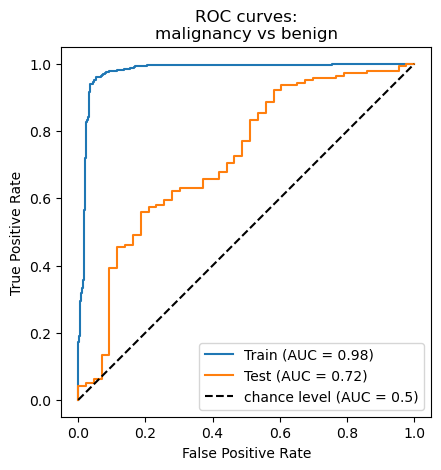

In [ ]:
pred_proba = best_model.predict_proba(test_X_rescaled_selected2)
train_proba = best_model.predict_proba(train_X_rescaled_selected2)

train_disp = RocCurveDisplay.from_predictions(
    train_y,
    train_proba[:, 1],
    name="Train",
)

ax = plt.gca()
RocCurveDisplay.from_predictions(
    test_y,
    pred_proba[:, 1],
    name="Test",
    ax=ax
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves:\nmalignancy vs benign")
plt.legend()
plt.show()

## Detection Error Tradeoff (DET) Curve 

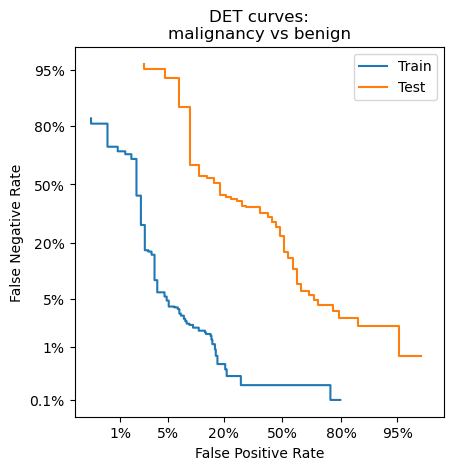

In [ ]:
pred_proba = best_model.predict_proba(test_X_rescaled_selected2)
train_proba = best_model.predict_proba(train_X_rescaled_selected2)

train_disp = DetCurveDisplay.from_predictions(
    train_y,
    train_proba[:, 1],
    name="Train",
)

ax = plt.gca()
DetCurveDisplay.from_predictions(
    test_y,
    pred_proba[:, 1],
    name="Test",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.title("DET curves:\nmalignancy vs benign")
plt.legend()
plt.show()

# Scratch

In [96]:


params = {'n_estimators': 47, 'max_depth': 7, 'gamma': 5.910530898532755, 'colsample_bytree': 0.7, 'lambda': 1.0857325635888906, 'alpha': 0.16600992085587696, 'subsample': 0.7}
# make final prediction on the test dataset 
if model_name == 'XGBoost': 
    check_model_optuna = XGBClassifier(**params)
elif model_name == 'RandomForest': 
    check_model_optuna = RandomForestClassifier(**params)
elif model_name == 'SVM': 
    check_model_optuna = svm.SVC(**params, probability=True)

# re-fitting RFCEV and classifier with the best parameters selected by optuna
#rfecv = RFECV(estimator=check_model_optuna, step=1, cv=cv, min_features_to_select=min_features_to_select, n_jobs=n_process, scoring='roc_auc')
#rfecv.fit(train_X_rescaled_selected1, train_y.squeeze(-1))
#check_train_X_rescaled_selected2 = rfecv.transform(train_X_rescaled_selected1)
#check_result = cross_validate(check_model_optuna, train_X_rescaled_selected1, train_y.squeeze(-1), cv=num_cv, scoring=make_scorer(custom_scorer), return_estimator=True) # Stratified Cross Validation is default

###### check_SFS feature selection
check_train_X_rescaled_selected1 = copy.copy(train_X_rescaled_selected1)
check_sfs = SequentialFeatureSelector(check_model_optuna, n_features_to_select='auto', direction='backward',tol=10)
check_train_X_rescaled_selected2 =check_sfs.fit_transform(check_train_X_rescaled_selected1, train_y)
"""
check_train_X_rescaled_selected2 = train_X_rescaled_selected1
"""

check_result = cross_validate(check_model_optuna, check_train_X_rescaled_selected2, train_y.squeeze(-1), cv=num_cv, scoring=scoring, return_estimator=True) # Stratified Cross Validation is default



# getting best model based on the check_result of cross validation 
#check_model = selecting_check_model(check_result)

for check_model in check_result['estimator']:
    # getting check_results from test set 
    #check_test_X_rescaled_selected1 = selector.transform(check_test_X_rescaled_selected)
    #### check_SFS feature selection
    check_test_X_rescaled_selected1 = copy.copy(test_X_rescaled_selected1)
    check_test_X_rescaled_selected2 = check_sfs.transform(check_test_X_rescaled_selected1)
    """
    check_test_X_rescaled_selected2 = check_test_X_rescaled_selected1
    """
    #check_test_X_rescaled_selected2 = rfecv.transform(check_test_X_rescaled_selected1)
    #ACC, AUC, F1 = getting_test_check_result(check_model, check_test_X_rescaled_selected2, test_y)

    check_ACC, check_balanced_ACC, check_AUC, check_F1, check_sensitivity_specificity, check_precision = getting_test_result(check_model, check_test_X_rescaled_selected2, test_y.squeeze(-1))
    print('The check_Result from the Best Model\nAccuracy: {:3f}. Balanced Accuracy: {:3f}. AUC: {:3f}. F1:{:3f}. Sensitivity/Specificity: {}. Precision: {}'.format(check_ACC, check_balanced_ACC, check_AUC, check_F1, check_sensitivity_specificity, check_precision))



KeyboardInterrupt: 